# Dual Limit Surface Noteobject
- Goal of this noteobject is to contain all of the code to run a dual limit surface planner
- Simulation is in Drake
- Planning uses CasADi
- Only other file this requires is table.sdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Dual Limit Surface Planning algorithm

Our planner solves the following optimization problem
$$ \min_{\vec{\tau}} \quad C_1\sum_{i=1}^n (\vec{q}_i - \hat{\vec{q}_i})^T(\vec{q}_i - \hat{\vec{q}_i}) 
+ C_2\sum_{i=3}^n \begin{bmatrix} \vec{q}_{i-2}^T & \vec{q}_{i-1}^T & \vec{q}_i^T \end{bmatrix} \bf{P} \begin{bmatrix} \vec{q}_{i-2}^T & \vec{q}_{i-1}^T & \vec{q}_i^T \end{bmatrix}$$

$$ \textrm{s.t.} \begin{bmatrix} \vec{q}_{i-1}^T & \vec{q}_{i}^T \end{bmatrix} \bf{K} \begin{bmatrix} \vec{q}_{i-1}^T & \vec{q}_{i}^T \end{bmatrix}^T > 0 \quad \forall i \in [2,\dots,n]$$

$$ \bf{P} =(\begin{bmatrix} 1 & -2 & 1\end{bmatrix} ^T\begin{bmatrix} 1 & -2 & 1\end{bmatrix} )\otimes \bf{I} $$

$$ \bf{K} =\begin{bmatrix} 1 & -1\\ -1 & 1\end{bmatrix} \otimes diag(k, k, -1) $$

In [2]:
#### DUAL LIMIT SURFACE PLANNING MODULE
import casadi as cs

def dual_limit_surface_cost(C1, C2, start_pose, end_pose, steps):
    '''
    Parameters:
    ===========
    @param C1         : (float) scalar representing cost scale for deviation of path from straight line from start to finish.
    @param C2         : (float) scalar representing cost scale on second order behavior of path.
    @param start_pose : (3x1 ndarray) [x,y,theta] 2d starting pose of object for interpolation
    @param end_pose   : (3x1 ndarray) [x,y,theta] 2d ending   pose of object for interpolation
    @param steps      : (int)   number of points to plan for from start to finish.

    Description:
    ============
    creates objective cost for optimization.

    Cost function will be seen as:
        J(q) = C1*(q-qhat).T @ (q-qhat) + C2*sum([qi-2,qi-1,qi].T @ P @ [qi-2,qi-1,qi])

    The C1 term is the deviation from start to finish
    The C2 term is the penalty scale on the second orderness of the path created.

    Returns:
    ========
    @return casadi.Function: qs -> cost.
    '''
    

    qs = cs.SX.sym('q', 3, steps)
    qhats = cs.SX(np.linspace(start_pose, end_pose, steps).squeeze().T)

    # deviation cost from line
    J = C1*cs.sum2(cs.sum1(((qs-qhats)**2)))

    #kronecker product applied on 3x3 matrix and I_{3x3} to make P.
    # P (x) I = [p11, p12, p13]     [1, 0, 0]   [p11 I, p12 I, p13 I]
    #           [p21, p22, p23] (x) [0, 1, 0] = [p21 I, p22 I, p23 I]
    #           [p31, p32, p33]     [0, 0, 1]   [p31 I, p32 I, p33 I]

    # second order penalty cost
    P = np.array([[1,-2,1]])
    P = cs.SX(np.kron(P.T @ P, np.eye(3))) # (9x9)
    qstack = cs.vertcat(qs[:,0:steps-2], qs[:,1:steps-1], qs[:,2:steps]) # (9xN)
    
    # for i in range(qstack.shape[1]):
        # J += C2*(qstack[:,i].T @ P @ qstack[:,i])
    J += C2*cs.sum2(cs.sum1((qstack.T @ P).T * qstack))

    #return as Function
    Jcost = cs.Function('cost_fn', [qs], [J])
    return Jcost

def dls_constraint_ineq(kv, inverse, steps):
    '''
    Parameters:
    ===========
    @param kv     
    @param inverse
    @param steps

    Description:
    ============
    returns calculations for left side of inequality constraint g(x) <= 0.

    Explicitly this is mainly a quadratic constraint which represents
    the ellipsoid constraint approximated for the dual limit contact model.

    Returns:
    ========
    @return casadi.Function: qs -> inequality LHS.
    '''

    #create K matrix derived from contact formulation in Dual Limit Surface
    K = np.array([[1,-1],
                  [-1,1]])
    K = np.kron(K,np.diag([kv,kv,-1]))
    K = cs.SX(K)
    qs = cs.SX.sym('x', 3, steps)

    qstack = cs.vertcat(qs[:,0:steps-1], qs[:,1:steps]) #6xN

    #apply quadratic
    
    inverse_multiplier = (1 if inverse else -1)
    # g_ineq = cs.SX.zeros(qstack.shape[1])
    # for i in range(qstack.shape[1]):
    #     g_ineq[i] = inverse_multiplier*(qstack[:,i].T @ K @ qstack[:,i])
    g_ineq = inverse_multiplier*cs.sum1((qstack.T @ K).T * qstack) # 1xN-1

    contact_ineq_fn = cs.Function('contact_fn', [qs], [g_ineq])

    ubg = [0]*qstack.shape[1]
    lbg = [-np.inf]*qstack.shape[1]
    return contact_ineq_fn, ubg, lbg

def dls_decision_constr(start_pose, end_pose, steps):
    ubx = [np.inf]*(3*steps)
    lbx = [-np.inf]*(3*steps)

    ubx[:3]  = start_pose.flatten().tolist()
    lbx[:3]  = start_pose.flatten().tolist()
    ubx[-3:] = end_pose.flatten().tolist()
    lbx[-3:] = end_pose.flatten().tolist()
    #the only constraint is making sure we don't change start and end pose
    return ubx, lbx

def limit_surface_plan(start_pose: np.ndarray, end_pose: np.ndarray, kv: float, C1: float, C2: float, steps:int = 10, inverse:bool = False):
    '''
    Parameters:
    ===========
    @param start_pose: (3x1 ndarray) [x,y,theta] 2d starting pose of object
    @param end_pose  : (3x1 ndarray) [x,y,theta] 2d ending   pose of object
    @param kv        : (float) double cone constant
    @param ka        : (float) scalar representing smoothness of path
    @param steps     : (int)   number of points to plan for from start to finish.
    @param inverse   : (bool)  whether kv^2 < w^2 or kv^2 > w^2 for double cone constraint

    Description:
    ============
    open-loop planner that performs optimization to solve a best path given contact
    dynamics.

    Returns:
    ========
    @return (3xN ndarray) each column is [x y theta]. a set of waypoints representing solved path
                          between start and end pose. N = number of waypoints = step param
    '''

    '''
        We aim to solve the quadratic constrained QP formulated as.

        min. q.T@Q@q + f@q + c
         q
        s.t.
             q.T@H@q <= bineq
             q       >= beq
             q       <= aeq
    '''
    qs = cs.SX.sym('q', 3, steps)
    cost_fn = dual_limit_surface_cost(C1, C2, start_pose, end_pose, steps)
    ineq_fn, ubg, lbg  = dls_constraint_ineq(kv, inverse, steps)
    ubq, lbq = dls_decision_constr(start_pose,end_pose, steps)

    options = {'ipopt.print_level':0}
    solver = cs.nlpsol('solver','ipopt', {'f': cost_fn(qs), 'x': qs.reshape((-1,1)), 'g': ineq_fn(qs)}, options)
    qs0 = np.linspace(start_pose, end_pose, steps).squeeze().T.flatten().tolist()
    
    solution = solver(x0=qs0, lbx=lbq, ubx=ubq, lbg=lbg, ubg=ubg)
    q_sol  = np.array(solution['x'].reshape((3,steps)))
    return q_sol

In [3]:
initial_pose = np.array([[0,0,0]]).T
goal_pose    = np.array([[0.0, 0.7, np.pi/2]]).T
kv = 0.5
C1 = 20 #path length penalty scale
C2 = 100 #k_a
steps = 30
q_sol = limit_surface_plan(initial_pose, goal_pose, kv, C1, C2,steps=steps)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   4.41ms ( 55.82us) 559.73us (  7.09us)        79
       nlp_g  |   2.66ms ( 33.72us) 327.28us (  4.14us)        79
  nlp_grad_f  |   5.38ms (112.15us) 691.65us ( 14.41us)        48
  nlp_hess_l  |   3.84ms ( 85.33us) 488.07us ( 10.85us)        45
   nlp_jac_g  |   2.50ms ( 53.11us) 318.01us (  6.77us)        47
       total  | 488.08ms (488.08ms)  62.81ms ( 62.81ms)         1


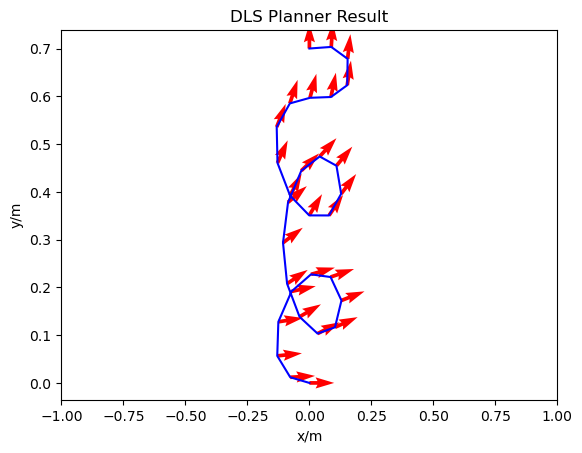

In [4]:
ts = np.linspace(0,q_sol.shape[1],q_sol.shape[1])
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(q_sol[0,:], q_sol[1,:], 'b')
ax.quiver(*q_sol[:2,:], np.cos(q_sol[-1,:]), np.sin(q_sol[-1,:]), color='r', scale=20)
ax.set_xlabel('x/m')
ax.set_ylabel('y/m')
ax.set_xlim(-1,1)
ax.set_title('DLS Planner Result')
plt.show()

## Helper Functions for registering objects 

In [5]:
from pydrake.multibody.plant import MultibodyPlant
from pydrake.geometry import Cylinder, ProximityProperties
from pydrake.multibody.tree import RigidBody
from pydrake.math import RigidTransform

def RegisterVisualShape(plant: MultibodyPlant, name: str, body: RigidBody,
                        shape, color=[1,0,0,1]):
    plant.RegisterVisualGeometry(
        body, RigidTransform(), shape, name, color
    )

def RegisterShape(plant: MultibodyPlant, name:str, body: RigidBody, 
                  shape, prop: ProximityProperties, color=[1,0,0,1], rt=RigidTransform()):
    
    if plant.geometry_source_is_registered():
        plant.RegisterCollisionGeometry(
            body, rt, shape, name, prop
        )
        plant.RegisterVisualGeometry(
            body, rt, shape, name, color
        )

## Hydroelastic Contact Helper Function

In [6]:
from pydrake.geometry import (
    AddContactMaterial, 
    ProximityProperties, 
    AddCompliantHydroelasticPropertiesForHalfSpace, 
    AddCompliantHydroelasticProperties, 
    AddRigidHydroelasticProperties,
    Meshcat
)
from pydrake.multibody.plant import MultibodyPlant, CoulombFriction

def AddContactModel(plant: MultibodyPlant, halfspace_slab=0.0, mu_static=0.0, **kwargs):
    '''
    Paramters:
    ==========
    @param plant
    @param half_space_slab
    @param mu_static

    @param kwargs (dictionary)
    ===============================================================================
    | Compliant Parameters                                                        |
    ===============================================================================
    | Key       | Value
    -------------------------------------------------------------------------------
    | hydro_mod   | - measure of stiffness of material (pressure over penetration). 
    |             | - float (Pa (N/m^2))
    -------------------------------------------------------------------------------
    | dissip      | - energy dampening property of contact on object.
    |             | - >0 float (s/m) recommended dissip \in [0,3] and default: 1
    -------------------------------------------------------------------------------
    | res_hint    | - controls fineness of meshes from shapes. 
    |             | - coarse (fast but not accurate), fine (slow but accurate)
    |             | - float (meters)
    -------------------------------------------------------------------------------
    | mu_static   | - coefficient of static friction
    |             | - >0 float.
    -------------------------------------------------------------------------------
    | mu_dynamic  | - coefficient of dynamic friction
    |             | - >0 float recommended to keep same as mu_static
    -------------------------------------------------------------------------------
    ===============================================================================
    | Rigid Parameters                                                            |
    ===============================================================================
    | Key       | Value
    -------------------------------------------------------------------------------
    | res_hint    | - controls fineness of meshes from shapes. 
    |             | - coarse (fast but not accurate), fine (slow but accurate)
    |             | - float (meters)
    -------------------------------------------------------------------------------
    | mu_static   | - coefficient of static friction
    |             | - >0 float. Doesn't just apply to hydroelastic
    -------------------------------------------------------------------------------
    | mu_dynamic  | - coefficient of dynamic friction
    |             | - >0 float recommended to keep same as mu_static
    -------------------------------------------------------------------------------
    '''
    prop = ProximityProperties()
    contact_type = "compliant" if "hydro_mod" in kwargs else "rigid"
    mu_dynamic = (kwargs["mu_dynamic"] if "mu_dynamic" in kwargs else mu_static)
    res_hint   = (kwargs["res_hint"] if "res_hint" in kwargs else 1.0)
    dissip     = (kwargs["dissip"] if "dissip" in kwargs else 1.0)
    AddContactMaterial(dissip, None, CoulombFriction(mu_static, mu_dynamic), prop)

    if contact_type == "rigid":
        AddRigidHydroelasticProperties(res_hint, prop)        

    elif contact_type == "compliant":
        hydro_mod = kwargs["hydro_mod"]
        if halfspace_slab == 0.0:
            AddCompliantHydroelasticProperties(res_hint, hydro_mod, prop)
        else:
            AddCompliantHydroelasticPropertiesForHalfSpace(halfspace_slab, hydro_mod, prop)

    return prop

## Helper Functions to Load and utilize End-Effector (Robot Finger)

In [7]:
### Setup End-Effector Module
from pydrake.multibody.tree import PrismaticJoint, RevoluteJoint
from pydrake.multibody.tree import RigidBody, SpatialInertia, UnitInertia
def AddCylinder(plant: MultibodyPlant, radius: float, length: float, name: str, 
                mass: float = 1.0, mu=1.0, color=[1,0,0,1], rt=RigidTransform()):
    '''
        Registers Cylinder Object (End-Effector shape)
    '''
    ## add cylinder to the plant
    cylinder = Cylinder(radius,length)
    instance = plant.AddModelInstance(name)

    inertia = UnitInertia.SolidCylinder(
        cylinder.radius(), cylinder.length(), [0, 0, 1]
    )
    body = plant.AddRigidBody(
        name,
        instance,
        SpatialInertia(
            mass=mass, p_PScm_E=np.array([0.0, 0.0, 0.0]), G_SP_E=inertia
        ),
    )

    dissip = 1e10
    hydro_mod = 1e10
    ## put in hydroelastic properties
    cylinder_prop = AddContactModel(plant, dissip=dissip, hydro_mod=hydro_mod, mu_static=mu, mu_dynamic=mu, res_hint=0.01)

    ## register collision geometry (hydroelastic + geometric/visual)
    RegisterShape(plant, name, body, cylinder, cylinder_prop, color, rt=rt)
    return instance

def MakeTiltedCylinderControllable(plant: MultibodyPlant, instance, name: str, rt=RigidTransform()):
    false_body1 = plant.AddRigidBody(
        f"{name}_false1",
        instance,
        SpatialInertia(0, [0, 0, 0], UnitInertia(0, 0, 0)),
    )
    false_body2 = plant.AddRigidBody(
        f"{name}_false2",
        instance,
        SpatialInertia(0, [0, 0, 0], UnitInertia(0, 0, 0)),
    )
    false_body3 = plant.AddRigidBody(
        f"{name}_false3",
        instance,
        SpatialInertia(0, [0, 0, 0], UnitInertia(0, 0, 0)),
    )
    R = rt.rotation().matrix()
    
    xaxis = R @ np.array([[1,0,0]]).T
    yaxis = R @ np.array([[0,1,0]]).T
    zaxis = R @ np.array([[0,0,1]]).T

    xaxis = xaxis.flatten().tolist()
    yaxis = yaxis.flatten().tolist()
    zaxis = zaxis.flatten().tolist()
    
    u_x = plant.AddJoint(
        PrismaticJoint(
            f"{name}_x",
            plant.world_frame(),
            plant.GetFrameByName(f"{name}_false1"),
            xaxis,
            -30.0,
            30.0
        )
    )
    u_y = plant.AddJoint(
        PrismaticJoint(
            f"{name}_y",
            plant.GetFrameByName(f"{name}_false1"),
            plant.GetFrameByName(f"{name}_false2"),
            yaxis,
            -30.0,
            30.0
        )
    )
    u_z = plant.AddJoint(
        PrismaticJoint(
            f"{name}_z",
            plant.GetFrameByName(f"{name}_false2"),
            plant.GetFrameByName(f"{name}_false3"),
            zaxis,
            -30.0,
            30.0
        )
    )
    w_z = plant.AddJoint(
        RevoluteJoint(
            f"{name}_wz",
            plant.GetFrameByName(f"{name}_false3"),
            plant.GetFrameByName(f"{name}"),
            zaxis
        )
    )

    plant.AddJointActuator(f"{name}_x", u_x)
    plant.AddJointActuator(f"{name}_y", u_y)
    plant.AddJointActuator(f"{name}_z", u_z)
    plant.AddJointActuator(f"{name}_wz", w_z)

## Helper Functions to add Ground, Object, and Table

In [8]:
### Add Object, Ground, and Table Module
from pydrake.geometry import Cylinder, HalfSpace, Box, ProximityProperties
TABLE_PATH = './assets/table.sdf'
def AddObject(plant: MultibodyPlant, name: str, lwh=(1.0,1.0,1.0), mass=1.0, mu=1.0, color=[1,0,0,1]):
    object_instance = plant.AddModelInstance(name)

    object_body = plant.AddRigidBody(f"{name}_body",
                object_instance,
                SpatialInertia(mass=mass,
                               p_PScm_E=np.array([0.0,0.0,0.0]),
                               G_SP_E=UnitInertia(1.0,1.0,1.0)
                               )
                )
    object = Box(*lwh)

    dissip = 1e4
    hydro_mod = 1e4

    object_props = AddContactModel(plant, dissip=dissip, hydro_mod=hydro_mod, mu_static=mu, res_hint=0.01)
    # object_props = AddContactModel(plant, mu_static=mu, res_hint=0.0001)
    RegisterShape(plant, name, object_body, object, object_props, color)
    return object_instance

def AddGround(plant: MultibodyPlant):
    ground_color = [0.5, 1.0, 0.5, 1.0]
    ground_prop = AddContactModel(plant, halfspace_slab=0.5, hydro_mod = 3e4, dissip=1.0, mu_static=1.0, res_hint=10)
    RegisterShape(plant, "GroundVisualGeometry", plant.world_body(), HalfSpace(), ground_prop, ground_color)

def AddTable(plant, scene_graph):
    parser = Parser(plant,scene_graph)
    table_instance = parser.AddModels(TABLE_PATH)[0]

## Wrap Planner with Logic

In [9]:
### Planner with choice between dual limit surface motion planning path or linear interpolated path
def create_path(initial_pose: np.ndarray, goal_pose: np.ndarray, time_span:float = 1,steps:int=30,use_dls:bool=True, kv=0.3):
    '''
    Creates a path from initial_pose to goal_pose with a given time span and number of steps.
    
    @param initial_pose: np.ndarray, the starting pose of the path
    @param goal_pose: np.ndarray, the ending pose of the path
    @param time_span: float, the time allotted for the path
    @param steps: int, the number of steps to generate the path
    @param use_dls: bool, whether to use damped least squares (DLS) to generate the path
    
    @return: (np.ndarray, np.ndarray), tuple of the generated path and associated timestamps
    '''
    
    timestamps = np.linspace(0,time_span,steps)
    if use_dls:
        C1 = 10
        C2 = 100 #k_a
        waypoints = limit_surface_plan(initial_pose, goal_pose, kv, C1, C2,steps=steps)
    else:
        waypoints = np.linspace(initial_pose, goal_pose, steps).squeeze().T
    
    return waypoints, timestamps

## Planning to Actuation Module for End-Effector
- We setup all of the modules related to PID force control on end-effector to obtain a desired position and twist
- Additionally, we setup logic to apply this for path-following

In [10]:
### End-Effector - Controller Module

from pydrake.multibody.plant import MultibodyPlant
from pydrake.math import RotationMatrix, RollPitchYaw, RigidTransform
from pydrake.systems.framework import LeafSystem
from pydrake.trajectories import PiecewisePose
from pydrake.systems.framework import LeafSystem, SystemOutput, Context, BasicVector
from pydrake.systems.primitives import Adder
from pydrake.systems.primitives import ConstantVectorSource

class ForcePD(LeafSystem):
    '''
    calculates force PD as follows
    
    power = kp*(desired_state - state) + kd*(desired_state_dot - state_dot)
    '''
    def __init__(self, state_size: int, kp: np.ndarray, ki: np.ndarray, kd: np.ndarray):
        LeafSystem.__init__(self)
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.state_size = state_size
        self.integral_error = np.zeros((state_size,))
        self.DeclareVectorInputPort("ee_state", state_size*2)
        self.DeclareVectorInputPort("desired_state", state_size*2)
        self.DeclareVectorOutputPort("pid_output", state_size, self.CalcOutput)
    def CalcOutput(self, context: Context, outputs: SystemOutput) -> None:
        state = self.get_input_port(0).Eval(context)
        desired_state = self.get_input_port(1).Eval(context)
        
        state_pos = state[:self.state_size]
        state_dot = state[self.state_size:]
                
        desired_state_pos = desired_state[:self.state_size]
        desired_state_dot = desired_state[self.state_size:]
        
        self.integral_error += (desired_state_pos - state_pos)
        
        
        P = self.kp * (desired_state_pos - state_pos)
        I = self.ki * (self.integral_error)
        D = self.kd * (desired_state_dot - state_dot)
        
        outputs.SetFromVector(P+D)

def waypoints2RT(waypoints: np.ndarray) -> [RigidTransform]:
    '''
    @param waypoints: (3xN)
    
    takes in waypoints and converts it to a list of RigidTransforms
    for drake.
    '''
    transforms = []
    for i in range(waypoints.shape[1]):
        x,y = waypoints[:,i][:2]
        theta = waypoints[:,i][-1]
        transforms.append(RigidTransform(RollPitchYaw(0,0,theta), np.array([x,y,0])))

    return transforms
def RT2waypoints(transform: RigidTransform, twist: np.ndarray) -> np.ndarray:
    '''
    @param transform: RigidTransform
    @param twist: np.ndarray (6,) representing (theta_xdot, theta_ydot, theta_zdot, xdot, ydot, zdot)
    
    takes in rigid transform and converts it to a waypoint
    '''
    
    x,y = transform.translation()[:2]
    theta = transform.rotation().ToRollPitchYaw().yaw_angle()
    theta_dot, xdot,ydot = twist[2:5]
    
    waypoint = np.array([x,y,theta,xdot,ydot,theta_dot])
    return waypoint

class PlannerOutput(LeafSystem):
    '''
    PathFollower takes in 
    PathFollower assumes a PID will be used for force.
    
    INPUT:
    -> boolean on when to turn on the path follower
    
    OUTPUT:
    -> outputs waypoints based on path given at the initializer
    '''
    def __init__(self, path: np.ndarray, ts: np.ndarray, starting_wp: np.ndarray = np.array([0,0,0])):
        LeafSystem.__init__(self)
        self.starting_wp = starting_wp
        rt_list: [RigidTransform] = waypoints2RT(path)
        
        self.curve: PiecewisePose = PiecewisePose.MakeLinear(ts.tolist(), rt_list)
        
        self.start_time = -1
        self.time_elapsed = -1
        
        self.DeclareVectorInputPort("switch", 1)
        self.DeclareVectorOutputPort("waypoint", 6, self.CalcOutput)
    def CalcOutput(self, context: Context, outputs: SystemOutput) -> None:
        turn_on = self.get_input_port(0).Eval(context)
        
        turn_on = turn_on[0] > 0.5
        
        if turn_on and self.start_time == -1:
            self.start_time = context.get_time()
        
        if turn_on:
            self.time_elapsed = context.get_time() - self.start_time
            pose: RigidTransform = self.curve.GetPose(self.time_elapsed)
            twist: np.ndarray = self.curve.GetVelocity(self.time_elapsed)
            
        else:
            pose = RigidTransform(RollPitchYaw(0,0,self.starting_wp[2]), np.array([self.starting_wp[0],self.starting_wp[1],0]))
            twist = np.zeros(6)
        
        waypoint = RT2waypoints(pose, twist)
        outputs.SetFromVector(waypoint)

## Planning Logic Module
- Take the controller module above and combine it with additional logic in simulation.
- This should handle higher-level things like when to start following the path, cancelling out gravity term, and formatting inputs/outputs.

In [11]:
## Planning2Actuation Module
from pydrake.systems.framework import LeafSystem, SystemOutput, Context, Diagram, DiagramBuilder
from pydrake.systems.primitives import Adder
from pydrake.systems.primitives import ConstantVectorSource

def AntiGravEE(kg: float, grav_constant: float) -> ConstantVectorSource:
    '''
    @params kg: float
    @params grav_constant: float
    
    
    returns a force that is equal to the weight of the end effector.
    '''
    mg = kg * np.array([0,0,grav_constant,0])
    return ConstantVectorSource(mg)

class EEPlannerLogic(LeafSystem):
    '''
    handles all of the logic of the EE planner.
    '''
    def __init__(self, wait_time):
        LeafSystem.__init__(self)
        self.wait_time = wait_time
        self.start_time = None
        self.starting = True
        
        self.DeclareVectorOutputPort("turn_on", 1, self.CalcOutput)
    def CalcOutput(self, context: Context, outputs: SystemOutput) -> None:
        if self.start_time is None:
            self.start_time = context.get_time()
        
        time_elapsed = context.get_time() - self.start_time
        
        turn_on = (time_elapsed - self.start_time) > self.wait_time
        turn_on = np.array([int(turn_on)])
        outputs.SetFromVector(turn_on)

class Force2ActuationEE(LeafSystem):
    '''
    waypoints will give PID output as a force in (x,y,theta)
    need to convert to (x,y,z,theta)
    '''
    def __init__(self):
        LeafSystem.__init__(self)
        self.DeclareVectorInputPort("force", 3)
        self.DeclareVectorOutputPort("actuation", 4, self.CalcOutput)
    def CalcOutput(self, context: Context, outputs: SystemOutput) -> None:
        force = self.get_input_port(0).Eval(context)
        actuation = np.zeros((4,))
        actuation[0] = force[0]
        actuation[1] = force[1]
        actuation[2] = 0
        actuation[3] = force[2]
        outputs.SetFromVector(actuation)

class EEState2Formatter(LeafSystem):
    '''
    This LeafSystem converts the full end-effector (EE) state to only the relevant states.
    The EE state is an 8-dimensional vector, but only the first, second, fourth, fifth, sixth, and eighth
    dimensions are relevant. This system takes in the full EE state and outputs a 6-dimensional vector
    containing only the relevant states.
    '''
    def __init__(self):
        LeafSystem.__init__(self)
        self.DeclareVectorInputPort("ee_state", 8)
        self.DeclareVectorOutputPort("ee_state_formatted", 6, self.CalcOutput)
    def CalcOutput(self, context: Context, outputs: SystemOutput) -> None:
        ee_state = self.get_input_port(0).Eval(context)
        ee_state_formatted = np.zeros((6,))
        ee_state_formatted[0] = ee_state[0]
        ee_state_formatted[1] = ee_state[1]
        ee_state_formatted[2] = ee_state[3]
        ee_state_formatted[3] = ee_state[4]
        ee_state_formatted[4] = ee_state[5]
        ee_state_formatted[5] = ee_state[7]
        
        outputs.SetFromVector(ee_state_formatted)
class EEPlanner(Diagram):
    '''
    Puts Everything Together
    '''
    def __init__(self, pressForce: np.ndarray, kp: np.ndarray, ki: np.ndarray, kd: np.ndarray, kg: float, grav_constant: float, wait_time: float, path: np.ndarray, ts: np.ndarray, initial_pose:np.ndarray):
        Diagram.__init__(self)
        
        builder = DiagramBuilder()
        
        stateformatter = builder.AddSystem(EEState2Formatter())
        #adding planner logic separated from planner following
        planner_logic  = builder.AddNamedSystem("planner_logic",EEPlannerLogic(wait_time))
        planner        = builder.AddNamedSystem("planner", PlannerOutput(path=path, ts=ts, starting_wp=initial_pose))
        
        builder.Connect(planner_logic.get_output_port(0), planner.get_input_port(0))
        
        #adding the workhorse controllers to allow path tracking
        
        
        pid_controller = builder.AddNamedSystem("pid_controller",ForcePD(3, kp, ki, kd))
        pid2actuation  = builder.AddNamedSystem("pid2actuation", Force2ActuationEE())
        
        #export ee_current_state
        builder.ExportInput(stateformatter.get_input_port(0), "ee_state")
        builder.Connect(stateformatter.get_output_port(0), pid_controller.get_input_port(0))
        
        #connect up planner to pid to ee actuation (force)
        builder.Connect(planner.get_output_port(0), pid_controller.get_input_port(1))
        builder.Connect(pid_controller.get_output_port(0), pid2actuation.get_input_port(0))
        
        #all feed forwards are in the correct force, so don't need to convert like pid
        gravity_ff     = builder.AddNamedSystem("anti_grav", AntiGravEE(kg, grav_constant))
        press_ff       = builder.AddNamedSystem("press_ff", ConstantVectorSource(pressForce))
        
        #sum up all contributions
        controller_summation = builder.AddNamedSystem("sum_forces",Adder(3,4))
        builder.Connect(pid2actuation.get_output_port(0), controller_summation.get_input_port(0))
        builder.Connect(gravity_ff.get_output_port(0), controller_summation.get_input_port(1))
        builder.Connect(press_ff.get_output_port(0), controller_summation.get_input_port(2))
        
        builder.ExportOutput(controller_summation.get_output_port(0), "actuation")
        builder.BuildInto(self)

## Simulation Module

In [12]:
### Abstract Class to contain simulation logic from drake
from pydrake.geometry import StartMeshcat
from pydrake.multibody.plant import MultibodyPlant, MultibodyPlantConfig, AddMultibodyPlant
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.analysis import Simulator

from abc import ABC, abstractmethod
class WorkStation(ABC):
    '''
        Abstract Base Class for Simulation
    '''
    def __init__(self, contact_model="hydroelastic_with_fallback",multibody_dt=1e-3,penetration_allowance=1e-3, visual=True):
        if contact_model != "hydroelastic_with_fallback" and contact_model != "point" and contact_model != "hydroelastic":
            raise ValueError("Wrong Contact Model")
        
        CONTACT_SURF = "triangle"
        self.config  = MultibodyPlantConfig()
        self.config.time_step = multibody_dt
        self.config.penetration_allowance = penetration_allowance
        self.config.contact_model = contact_model
        self.config.contact_surface_representation = CONTACT_SURF
        # self.config.sap_near_rigid_threshold = 0.01
        self.config.discrete_contact_approximation = "tamsi"
        self.visual = visual

    #must be overloaded or else you can't simulate
    @abstractmethod
    def setup_simulate(self, builder: DiagramBuilder, plant: MultibodyPlant, scene_graph):
        raise NotImplementedError

    @abstractmethod
    def initialize_simulate(self, plant: MultibodyPlant, plant_context):
        raise NotImplementedError
    
    def run(self, simulation_time=10.0, realtime_rate=1.0):
        if self.visual:
            self.meshcat = StartMeshcat()
        builder = DiagramBuilder()
        plant, scene_graph = AddMultibodyPlant(self.config, builder)

        self.setup_simulate(builder, plant, scene_graph)

        diagram   = builder.Build()
        simulator = Simulator(diagram)
        plant_context = plant.GetMyContextFromRoot(simulator.get_mutable_context())
        self.initialize_simulate(plant, plant_context)
        diagram.ForcedPublish(simulator.get_context())

        simulator.Initialize()
        simulator.set_target_realtime_rate(realtime_rate)
        simulator.AdvanceTo(simulation_time)

### Tilted Simulation

In [13]:
from pydrake.visualization import AddDefaultVisualization
from pydrake.math import RigidTransform, RollPitchYaw
from pydrake.multibody.plant import MultibodyPlant
from pydrake.multibody.parsing import Parser
from pydrake.systems.framework import DiagramBuilder, LeafSystem

START_POSE = np.array([0.0,0,0])
GOAL_POSE = np.array([0.0,0.5,np.pi])
#Logic to fix position of end-effector
class FixEECoordinates(LeafSystem):
    def __init__(self, rt: RigidTransform, table_to_world: RigidTransform):
        LeafSystem.__init__(self)
        self.DeclareVectorInputPort("ee_state", 8)
        self.DeclareVectorOutputPort("ee_state_fixed", 8, self.CopyStateOut)
        self.rt = rt
        self.table_to_world = table_to_world
        
    def CopyStateOut(self, context, output) -> None:
        ee_state = self.get_input_port(0).Eval(context)
        ee_state_fixed = ee_state
        ee_state_fixed[:3] = ee_state[:3] - self.table_to_world.rotation().matrix().T @ self.table_to_world.translation()
        output.SetFromVector(ee_state_fixed)


class SimpleTiltedStation(WorkStation):
    '''
    very similar to the non-tilted case.
    '''
    GRAVITY_CONSTANT = 9.83
    def __init__(self, initial_pose = START_POSE, goal_pose = GOAL_POSE, tilt_angle = np.pi/8):
        WorkStation.__init__(self, "hydroelastic_with_fallback", multibody_dt=1e-3,penetration_allowance=1e-10,visual=True)
        self.initial_pose = initial_pose
        self.goal_pose = goal_pose
        self.tilt_angle = tilt_angle
        
        self.antigrav_spatial_force = np.array([0,0,SimpleTiltedStation.GRAVITY_CONSTANT,0,0,0])
        
        self.table_to_world = RigidTransform(RollPitchYaw(0,tilt_angle,0), np.array([0,0,1.0]))
        self.object_to_world  = RigidTransform(RollPitchYaw(0,0,initial_pose[2]), np.array([initial_pose[0],initial_pose[1],0.00])) @ self.table_to_world
        
        self.pub = None
    def setup_simulate(self, builder: DiagramBuilder, plant: MultibodyPlant, scene_graph):
        initial_pose = self.initial_pose
        goal_pose = self.goal_pose
        
        
        self.rt_tilted = RigidTransform(RollPitchYaw(0,self.tilt_angle,0), np.array([0,0,0]))
        # end effector params
        cylinder_mass = 1.0
        cylinder_radius = 0.02
        cylinder_length = 0.1
        cylinder_mu = 0.3
        cylinder_color = [1,0,0,0.5]
        self.ee_instance    = AddCylinder(plant,cylinder_radius, 
                                            cylinder_length, "end_effector", 
                                            cylinder_mass, cylinder_mu,
                                            cylinder_color, rt=self.rt_tilted)
        
        object_lwh = (0.25,0.25,0.02)
        object_mass = 0.05
        object_mu = 0.1
        object_color = [0,0,1,0.3]
        object_instance  = AddObject(plant,"object", object_lwh, 
                                    object_mass, object_mu, object_color)
        
        MakeTiltedCylinderControllable(plant, self.ee_instance, "end_effector", self.rt_tilted)
        
        #add table and ground
        parser = Parser(plant,scene_graph)
        table_instance = parser.AddModels(TABLE_PATH)[0]
        AddGround(plant)
        plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("table_body", table_instance), self.table_to_world)
        plant.mutable_gravity_field().set_gravity_vector(np.array([0,0,-SimpleTiltedStation.GRAVITY_CONSTANT]))
        plant.Finalize()
        
        
        kp = np.array([50.0,50.0,0.3])
        ki = np.array([0.0,0.0,0.0])
        kd = np.array([100.0,100.0,0.3])
        
        ### NOTE: simple PD controller for checking
        path, ts = create_path(initial_pose, goal_pose, time_span=80.0, steps=30, kv=0.5,use_dls=True)
        pressForce = np.array([0.0,0.0,-15.0,0.0])
        pressForce += np.array([-object_mass*SimpleTiltedStation.GRAVITY_CONSTANT*np.sin(self.tilt_angle),0,0,0])
        controller = builder.AddSystem(EEPlanner(pressForce,kp=kp,ki=ki,kd=kd,kg=cylinder_mass,grav_constant=SimpleTiltedStation.GRAVITY_CONSTANT,wait_time=10.0,path=path,ts=ts, initial_pose=initial_pose.flatten()))
        # controller = builder.AddSystem(ConstantVectorSource(pressForce))
        fix_state = builder.AddSystem(FixEECoordinates(self.rt_tilted, self.table_to_world))
        
        #make connections w/ fixed ee coordinate
        builder.Connect(plant.get_state_output_port(self.ee_instance), fix_state.get_input_port(0))
        builder.Connect(fix_state.get_output_port(0), controller.get_input_port(0))
        builder.Connect(controller.get_output_port(), plant.get_actuation_input_port(self.ee_instance))
        
        AddDefaultVisualization(builder, self.meshcat)
        
    def initialize_simulate(self, plant: MultibodyPlant, plant_context):
        vec = np.array([self.table_to_world.translation()[0],self.table_to_world.translation()[1], 1.00, 0])
        vec[:3] = self.rt_tilted.rotation().matrix().T @ vec[:3]
        vec[2] += 0.025 + 0.03
        plant.SetPositions(plant_context, self.ee_instance, vec)
        
        plant.SetFreeBodyPose(
            plant_context,
            plant.GetBodyByName('object_body'),
            self.object_to_world)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from pydrake.math import RigidTransform, RollPitchYaw
CONTACT_MODEL = "hydroelastic_with_fallback"
MULTIBODY_DT = 5e-3
PENETRATION_ALLOWANCE = 1e-5
SIMULATION_TIME = 100.0
SIM_REALTIME_RATE = 1000.0
tilted_angle = np.pi/6
station = SimpleTiltedStation(tilt_angle=tilted_angle)
station.run(SIMULATION_TIME,SIM_REALTIME_RATE)

INFO:drake:Meshcat listening for connections at http://localhost:7000


RuntimeError: error: Error finding file [/home/andang/ar-notebook-submission/./object/table.sdf].